In [1]:
import sys
import warnings
import metatensor
from itertools import product
from ase.io import read

import numpy as np
from metatensor import (
    Labels,
    TensorBlock,
    TensorMap,
)

from scipy.spatial.transform import Rotation as R
from tqdm.auto import tqdm
from skmatter.preprocessing import StandardFlexibleScaler

from anisoap.representations.radial_basis import (
    GTORadialBasis,
    MonomialBasis,
)
from anisoap.representations.ellipsoidal_density_projection import (
    EllipsoidalDensityProjection,
)

import matplotlib.pyplot as plt

In [3]:
ell_frames = read("../ellipsoids.xyz", "0:2")
ell_frames_translation = read("../ellipsoids.xyz", "0:2")
ell_frames_rotation = read("../ellipsoids.xyz", "0:2")

# This is to make sure the ell_frames list calls c_diameter[] rather than c_diameter and to update the diameters of ellipsoids to be 3,3, and 1.


def update_diameters_and_variablename(frames):
    for frame in frames:
        for i in range(1, 4):
            old = f"c_diameter{i}"
            new = f"c_diameter[{i}]"
            if old in frame.arrays:
                frame.arrays[new] = frame.arrays[old]
            frame.arrays[new] = np.ones(len(frame)) * (3.0 if i < 3 else 1.0)


update_diameters_and_variablename(ell_frames)
update_diameters_and_variablename(ell_frames_translation)
update_diameters_and_variablename(ell_frames_rotation)

In [4]:
# Translation vector is used to demonstrate the power spectrum of ellipsoidal representations are invariant of translation in positions.

translation_vector = np.array([2.0, 2.0, 2.0])
for frame in ell_frames_translation:
    frame.arrays["positions"] += translation_vector

In [5]:
lmax = 5
nmax = 3

AniSOAP_HYPERS = {
    "max_angular": lmax,
    "max_radial": nmax,
    "radial_basis_name": "gto",
    "rotation_type": "quaternion",
    "rotation_key": "c_q",
    "cutoff_radius": 7.0,
    "radial_gaussian_width": 1.5,
    "basis_rcond": 1e-8,
    "basis_tol": 1e-4,
}

In [6]:
calculator = EllipsoidalDensityProjection(**AniSOAP_HYPERS)
power_spectrum_original = calculator.power_spectrum(ell_frames, AniSOAP_HYPERS)
power_spectrum_translated = calculator.power_spectrum(
    ell_frames_translation, AniSOAP_HYPERS
)

# Compare the power_specturm_original and power_spectrum_translated to determine if the power spectrum is translation invariant

if np.allclose(power_spectrum_original, power_spectrum_translated):
    print("Power spectrum has translation invariance")
else:
    print("Power spectrum has no translation invariance")

Power spectrum has translation invariance


/home/lucasortengren/miniforge3/envs/ocsp/lib/python3.12/site-packages/anisoap/representations/ellipsoidal_density_projection.py:554: UserWarning: In quaternion mode, quaternions are assumed to be in (w,x,y,z) format.
  warnings.warn(


In [7]:
ell_frames_rotation[0].arrays["c_q"]

array([[ 0.15965019,  0.67170996, -0.07507814,  0.71950039],
       [-0.213207  , -0.03290243,  0.26500539,  0.93980442]])

In [8]:
quaternion = [1, 2, 0, -3]

q_rotation = R.from_quat(quaternion, scalar_first=True)

for frames in ell_frames_rotation:
    frames.arrays["c_q"] = R.as_quat(
        q_rotation * R.from_quat(frames.arrays["c_q"], scalar_first=True),
        scalar_first=True,
    )

In [9]:
power_spectrum_rotation = calculator.power_spectrum(ell_frames_rotation, AniSOAP_HYPERS)

# Compare the power_specturm_original and power_spectrum_rotation to determine if the power spectrum is rotation invariant
# Note that due to numerical stability, the rotated frames cannot exactly match the power spectrum of the original -- there will be 
if np.allclose(power_spectrum_original, power_spectrum_rotation, rtol=1e-2, atol=1e-2):
    print("Power spectrum has rotation invariance (with lenient tolerances)")
else:
    print("Power spectrum has no rotation invariance")

Power spectrum has rotation invariance (with lenient tolerances)


Text(0.5, 1.0, 'Frame 1, Original vs Rotated')

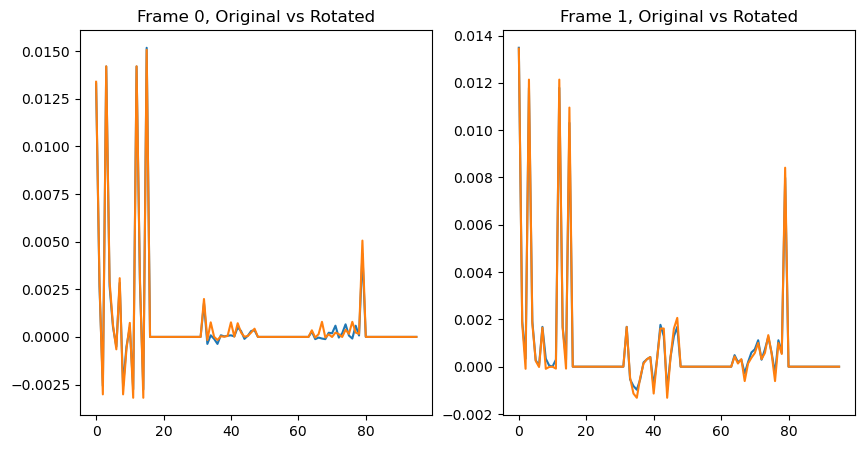

In [10]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].plot(power_spectrum_rotation.T[:,0])
axs[0].plot(power_spectrum_original.T[:,0])
axs[0].set_title("Frame 0, Original vs Rotated")
axs[1].plot(power_spectrum_rotation.T[:,1])
axs[1].plot(power_spectrum_original.T[:,1])
axs[1].set_title("Frame 1, Original vs Rotated")
